# Run eQTL Analysis

This notebook coordinates and executes the eQTL analysis. This notebook is
specialized for the Frazer lab cluster. Since running the entire analysis is 
time consuming, I generally run it "by hand," starting jobs for groups of
genes at different times. I've included instructions at various points below.

In [323]:
import cPickle
import datetime
import glob
import gzip
import os
import random
import re
import shutil
import subprocess
import time
import uuid

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

random.seed(20150605)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
outdir = os.path.join(ciepy.root, 'output',
                      'run_eqtl_analysis')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'run_eqtl_analysis')
cpy.makedir(private_outdir)

In [3]:
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'gene_to_regions.p')
gene_to_regions = cPickle.load(open(fn, 'rb'))

exp = pd.read_table(os.path.join(ciepy.root, 'output', 'eqtl_input', 
                                 'tpm_log_filtered_phe_std_norm_peer_resid.tsv'), index_col=0)

## SGE

The `run_emmax_sge` method will submit a job for a gene. I currently ask for 
16Gb of RAM per job and four cores. If you ask for less cores, more jobs will run
per node but all of the IO seems to slow the jobs down. Many genes probably need
less than 16Gb of RAM but some need more. The `mem_needed` method was my attempt
at estimating how much memory a job would need but it wasn't working well.
I think the memory needed scales with the number of variants (which `num_variants`
can tell you), so I could go and monitor the amount of memory used versus
the number of variants. However, I didn't have a big problem with jobs failing when 
using 16Gb of memory (it seems like ~430 genes failed and had to be run again).

In [5]:
cpy.makedir(os.path.join(private_outdir, 'sge_scripts'))
cpy.makedir(os.path.join(private_outdir, 'logs'))

In [255]:
def num_variants(vcf, gene_id, tempdir, regions, samples, bcftools_path):
    # This doesn't include CNVs but there aren't many of those.
    import ciepy

    samples = pd.read_table(samples, header=None, squeeze=True)
    fn = os.path.join(tempdir, '{}.vcf.gz'.format(gene_id))
    c = ('{} view {} -q 0.05:minor -m2 -M2 -r {} -s {} -O u | '
         '{} filter -m x -O v | grep -v \\# | wc -l'.format(
             bcftools_path,
             vcf,
             regions,
             ','.join(samples.values),
             bcftools_path,
             fn))
    num = int(subprocess.check_output(c, shell=True).strip())
    return num

def mem_needed(n):
    # CURRENTLY DEPRECATED.
    # n = number of variants
    # This is based on some empirical data.
    # The last + 3 is a fudge factor. Increase if many jobs are failing.
    return np.round(0.001786 * n + 1.079206 + 3, 1)

def make_variant_cov(res_files, out):
    vcf = os.path.join(ciepy.root, 'private_output/eqtl_input/filtered_all/0000.vcf.gz')
    cnv_vcf = os.path.join(ciepy.root, 'private_output', 'cnv_processing', 'emmax_sorted.vcf.gz')
    cov = os.path.join(ciepy.root, 'output', 'eqtl_input', 'emmax_sex_only.tsv')
    covariates = pd.read_table(cov, index_col=0, header=None, squeeze=True)
    new_covariates = pd.DataFrame({'sex':covariates})
    for i,fn in enumerate(res_files):
        res = ciepy.read_emmax_output(fn)
        res = res[res.PVALUE == res.PVALUE.min()]
        i = res.index[0]
        if 'CNV' in res.ix[i, 'MARKER_ID']:
            vcf_reader = pyvcf.Reader(open(cnv_vcf))
        else:
            vcf_reader = pyvcf.Reader(open(vcf))
        res = vcf_reader.fetch(res.ix[i, 'CHROM'], res.ix[i, 'BEG'], res.ix[i,'END'])
        r = res.next()
        new_covariates[i] = 0
        hets = set([x.sample for x in r.get_hets()]) & set(new_covariates.index)
        halts = set([x.sample for x in r.get_hom_alts()]) & set(new_covariates.index)
        new_covariates.ix[hets, i] = 1
        new_covariates.ix[halts, i] = 2
    new_covariates.to_csv(out, sep='\t', header=None)

def run_emmax_sge(gene_id, mem=16, queue=None, res_files=None):
    """
    """
    vcf = os.path.join(ciepy.root, 'private_output/eqtl_input/filtered_all/0000.vcf.gz')
    cnv_vcf = os.path.join(ciepy.root, 'private_output', 'cnv_processing', 'emmax_sorted.vcf.gz')
    samples = os.path.join(ciepy.root, 'output', 'eqtl_input', 'emmax_samples.tsv')
    regions = ','.join([x[3:] for x in gene_to_regions[gene_id]])
    #num = num_variants(vcf, gene_id, outdir, regions, samples, 'bcftools')
    #mem = mem_needed(num)
    
    exp = os.path.join(ciepy.root, 'output', 'eqtl_input', 
                       'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
    kin = os.path.join(ciepy.root, 'output', 'eqtl_input', 'wgs.kin')
    toutdir = os.path.join(private_outdir, 'results', gene_id)
    cov = os.path.join(ciepy.root, 'output', 'eqtl_input', 'emmax_sex_only.tsv')
    
    # If one or more emmax results files are provided, we'll get the most significant
    # variant from each file and add that as a covariate. We'll write the new covariate
    # file in the gene's output directory.
    if res_files:
        toutdir = os.path.join(private_outdir, 'results{}'.format(len(res_files) + 1), 
                               gene_id)
        cpy.makedir(toutdir)
        covariates = pd.read_table(cov, index_col=0, header=None, squeeze=True)
        for fn in res_files:
            cov = os.path.join(toutdir, '{}.cov'.format(gene_id))
            make_variant_cov(res_files, cov)
    else:
        cpy.makedir(toutdir)

    res = datetime.datetime.now()
    date = re.sub(r'\D', '_', str(res))
    fn = os.path.join(private_outdir, 'sge_scripts', '{}_{}.sh'.format(gene_id, date))
    with open(fn, 'w') as f:
        f.write('#!/bin/bash\n\n')
        f.write('#$ -N emmax_{}_{}\n'.format(gene_id, date))
        if queue:
            f.write('#$ -l {}\n'.format(queue))
            if queue == 'opt':
                mem = mem / 2.
        num_threads = 4
        f.write('#$ -l h_vmem={}G\n'.format(mem / num_threads))
        #f.write('#$ -l h_vmem=1G\n')
        f.write('#$ -pe smp {}\n'.format(num_threads))
        f.write('#$ -S /bin/bash\n')
        f.write('#$ -o {}/emmax_{}_{}.out\n'.format(
                os.path.join(private_outdir, 'logs'), gene_id, date))
        f.write('#$ -e {}/emmax_{}_{}.err\n\n'.format(
                    os.path.join(private_outdir, 'logs'), gene_id, date))
        f.write('module load cardips/1\n')
        f.write('source activate cie\n\n')
        
        c = 'python {} \\\n\t'.format(os.path.join(ciepy.root, 'scripts', 'run_emmax.py'))
        c += ' \\\n\t'.join([
                gene_id,
                '{},{}'.format(vcf, cnv_vcf),
                regions,
                exp,
                samples,
                kin,
                toutdir,
                '-c {}'.format(cov),
            ])
        f.write(c + '\n\n')
    subprocess.check_call('qsub {}'.format(fn), shell=True)
    
def get_jobs():
    """Get info about jobs currently running."""
    # Get jobs currently waiting to start or started.
    running = !qstat -r | grep jobname
    running = [x.split()[-1] for x in running if 'emmax_' in x]
    # Get all submission scripts created.
    fns = glob.glob(os.path.join(private_outdir, 'sge_scripts', '*.sh'))
    jobnames = ['emmax_' + os.path.splitext(os.path.split(x)[1])[0] for x in fns]
    genes = [os.path.split(x)[1].split('_')[0] for x in fns]
    jobs = pd.DataFrame(np.array(fns).T, index=jobnames, columns=['path'])
    jobs = pd.DataFrame([fns, genes], columns=jobnames, index=['path', 'gene']).T
    jobs['status'] = 'finished'
    # For now, running means either the job is waiting to start or has started.
    jobs.ix[running, 'status'] = 'running'
    return jobs

def get_genes(jobs):
    """Get job info about genes that we are analyzing."""
    genes = [os.path.split(x)[1] for x in glob.glob(os.path.join(private_outdir, 'results', 'ENSG*'))]
    genes = pd.DataFrame(index=genes)
    genes['status'] = 'incomplete'
    min_pvals = glob.glob(os.path.join(private_outdir, 'results', 'ENSG*', 'permuted_pvalues.tsv'))
    genes.ix[[x.split('/')[-2] for x in min_pvals], 'status'] = 'complete'
    genes['job_status'] = 'finished'
    # If there is any running job with this gene, we want to mark the job_status
    # as running.
    genes.ix[jobs.ix[jobs.status == 'running', 'gene'], 'job_status'] = 'running'
    return genes

### `all` queue

This cell will submit jobs to the `all` queue. The variable `num_to_submit`
controls how many jobs to submit.

I just load balance the `all` and `opt` queues myself as the jobs finish. For instance,
if I see the `opt` queue has a lot of jobs queued and `all` doesn't, I submit some jobs to
`all`. I don't see a big difference in the speed between the two queues.

In [465]:
todo = list(set(exp.index) - 
            set([os.path.split(x)[1] for x in glob.glob(os.path.join(private_outdir, 'results', '*'))]))
todo = [x for x in todo if gene_info.ix[x, 'chrom'] not in ['chrX', 'chrY', 'chrM']]

In [ ]:
todo = list(set(exp.index) - 
            set([os.path.split(x)[1] for x in glob.glob(os.path.join(private_outdir, 'results', '*'))]))
todo = [x for x in todo if gene_info.ix[x, 'chrom'] not in ['chrX', 'chrY', 'chrM']]

# Remove failed genes. I'll wait to resubmit these with more memory.
if os.path.exists(os.path.join(private_outdir, 'failed.txt')):
    with open(os.path.join(private_outdir, 'failed.txt')) as f:
        failed = [x.strip() for x in f.readlines()]
    todo = list(set(todo) - set(failed))

# Set num_to_submit to the number of jobs you want to submit.
num_to_submit = len(todo)
ind = 0
while len(todo) > 0 and ind < num_to_submit:
    run_emmax_sge(todo[ind])
    ind += 1

### `opt` queue

This cell will submit jobs to the `opt` queue. The variable `num_to_submit`
controls how many jobs to submit. `run_emmax_sge` will cut the memory in half
for `opt` jobs since they have less memory. If a gene fails in the `opt` queue 
due to memory it may work in the `all` queue.

In [ ]:
todo = list(set(exp.index) - 
            set([os.path.split(x)[1] for x in glob.glob(os.path.join(private_outdir, 'results', '*'))]))
todo = [x for x in todo if gene_info.ix[x, 'chrom'] not in ['chrX', 'chrY', 'chrM']]

# Remove failed genes. I'll wait to resubmit these with more memory.
if os.path.exists(os.path.join(private_outdir, 'failed.txt')):
    with open(os.path.join(private_outdir, 'failed.txt')) as f:
        failed = [x.strip() for x in f.readlines()]
    todo = list(set(todo) - set(failed))

# Set num_to_submit to the number of jobs you want to submit.
num_to_submit = len(todo)
ind = 0
while len(todo) > 0 and ind < num_to_submit:
    run_emmax_sge(todo[ind], queue='opt')
    ind += 1

In [274]:
# Submit failed genes with more memory.
if os.path.exists(os.path.join(private_outdir, 'failed.tsv')):
    jobs = get_jobs()
    genes = get_genes(jobs)
    failed = pd.read_table(os.path.join(private_outdir, 'failed.tsv'), index_col=0, 
                           header=None, squeeze=True)
    todo = list(set(failed.index) - set(genes.index))
    for gene in todo:
        mem = (failed[gene] + 1) * 16
        print(gene, mem)
        run_emmax_sge(gene, mem=mem)
        #run_emmax_sge(gene, mem=mem * 2, queue='opt')

('ENSG00000123243.10', 32)


### Look for failed jobs

Some genes have errors when they are running. This can happen if I don't request enough memory 
for instance. Genes that fail won't have `minimum_pvalues.tsv` files even when their job finishes. 
I want to identify these genes and remove their output directory so they will be run in a new job. 
I think these genes often leave behind their temp directory so I have to go delete those too.

In [309]:
todo = list(set(exp.index))
todo = [x for x in todo if gene_info.ix[x, 'chrom'] not in ['chrX', 'chrY', 'chrM']]
print('{:,} total genes to do.'.format(len(todo)))

17,769 total genes to do.


The table below shows how many genes' jobs are running. The number in the bottom
left cell (incomplete, finished) indicates jobs that failed.

In [310]:
jobs = get_jobs()
genes = get_genes(jobs)

pd.crosstab(genes.status, genes.job_status)

job_status,finished,running
status,,
complete,17768,0
incomplete,0,1


Any genes that are incomplete but whose jobs are finished had errors. I need 
to delete their temp directories and the output directories and try resubmitting.
I keep track of the failed genes so I can wait to resubmit them with more memory.
The file `failed.tsv` has the gene ID and the number of times the gene failed. I
increase the RAM in proportion to the number of times the gene fails. So if it has failed
three times, I'll give it $3 * 16 = 48$ Gb of RAM the next time I submit, etc.

In [273]:
# Write failed genes to file.
new_failed = list(genes[(genes.status == 'incomplete') & (genes.job_status == 'finished')].index)
if len(new_failed) > 0:
    new_failed = list(genes[(genes.status == 'incomplete') & (genes.job_status == 'finished')].index)
    if os.path.exists(os.path.join(private_outdir, 'failed.tsv')):
        failed = pd.read_table(os.path.join(private_outdir, 'failed.tsv'), squeeze=True, 
                               header=None, index_col=0)
        if len(set(failed.index) & set(new_failed)) > 0:
            failed[list(set(failed.index) & set(new_failed))] += 1
        t = pd.Series(1, index=list(set(new_failed) - set(failed.index)))
        failed = pd.concat([t, failed])
    else:
        failed = pd.Series(1, index=new_failed)
    failed.to_csv(os.path.join(private_outdir, 'failed.tsv'), header=None, sep='\t')

    # Remove output directories.
    dys = [os.path.join(private_outdir, 'results', g) for g in 
           genes[(genes.status == 'incomplete') & (genes.job_status == 'finished')].index]
    c = ' ; '.join(['if [ -d "{0}" ]; then rm -r {0} ; fi'.format(dy) for dy in dys])
    subprocess.check_call(c, shell=True)

    # Delete temp directories if they exist.
    dys = ['/dev/shm/{}'.format(g) for g in 
           genes[(genes.status == 'incomplete') & (genes.job_status == 'finished')].index]
    s = ' ; '.join(['if [ -d "{0}" ]; then rm -r {0} ; fi'.format(dy) for dy in dys])
    c = 'pdsh -g n "{}"'.format(s)
    subprocess.check_call(c, shell=True)

Sometimes I may accidentally submit a job for a gene that already has a job submitted.
This attempts to fix that.

In [122]:
# Kill jobs and delete tempdirs for repeat genes. This is necessary when a job
# is submitted (by accident) for a gene that is already complete.
g = genes[genes.status + '-' + genes.job_status == 'complete-running'].index
if len(g) > 0:
    t = jobs[jobs.gene.apply(lambda x: x in g)]
    for i in t.index:
        try:
            subprocess.check_call('qdel {}'.format(i), shell=True)
        except:
            continue

    # Delete temp directories.

    def chunks(l, n):
        """Yield successive n-sized chunks from l."""
        for i in xrange(0, len(l), n):
            yield l[i:i+n]
    cs = chunks(['/dev/shm/{}'.format(x) for x in g], 500)
    while True:
        try:
            dys = cs.next()
            s = ' ; '.join(['if [ -d "{0}" ]; then rm -r {0} ; fi'.format(dy) for dy in dys])
            c = 'pdsh -g n "{}"'.format(s)
            subprocess.check_call(c, shell=True)
        except StopIteration:
            break

In [ ]:
2 + 

## Secondary etc. QTLs

I want to search for secondary, tertiary, etc. eQTLs for genes that had one significant
eQTL.

In [360]:
qvalues = pd.read_table(os.path.join(ciepy.root, 'output', 'eqtl_processing',
                                     'qvalues.tsv'), index_col=0)
sig = qvalues[qvalues.sig]

In [ ]:
todo = list(set(sig.index) - 
            set([os.path.split(x)[1] for x in glob.glob(os.path.join(private_outdir, 'results2', '*'))]))

# Remove failed genes. I'll wait to resubmit these with more memory.
if os.path.exists(os.path.join(private_outdir, 'failed2.txt')):
    with open(os.path.join(private_outdir, 'failed2.txt')) as f:
        failed = [x.strip() for x in f.readlines()]
    todo = list(set(todo) - set(failed))

# Set num_to_submit to the number of jobs you want to submit.
num_to_submit = len(todo) / 2
ind = 0
while len(todo) > 0 and ind < num_to_submit:
    gene_id = todo[ind]
    rfn = os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'results',
                       gene_id, '{}.tsv'.format(gene_id))
    run_emmax_sge(gene_id, res_files=[rfn])
    ind += 1

In [413]:
todo = list(set(sig.index) - 
            set([os.path.split(x)[1] for x in glob.glob(os.path.join(private_outdir, 'results2', '*'))]))

# Remove failed genes. I'll wait to resubmit these with more memory.
if os.path.exists(os.path.join(private_outdir, 'failed2.txt')):
    with open(os.path.join(private_outdir, 'failed2.txt')) as f:
        failed = [x.strip() for x in f.readlines()]
    todo = list(set(todo) - set(failed))

# Set num_to_submit to the number of jobs you want to submit.
num_to_submit = len(todo)
ind = 0
while len(todo) > 0 and ind < num_to_submit:
    gene_id = todo[ind]
    rfn = os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'results',
                       gene_id, '{}.tsv'.format(gene_id))
    run_emmax_sge(gene_id, queue='opt', res_files=[rfn])
    ind += 1

In [483]:
s = glob.glob(os.path.join(private_outdir, 'results2', '*'))
s = [os.path.split(x)[1] for x in s]
fns = glob.glob(os.path.join(private_outdir, 'results2', '*', 'permuted_pvalues.tsv'))
g = [x.split('/')[-2] for x in fns]
jobs = !qstat -r | grep jobname | tr -s ' ' | cut -d ' ' -f 4
jobs = [x for x in jobs if 'emmax' in x]
jobs = [x.split('_')[1] for x in jobs]

# Write failed genes to file.
new_failed = set(s) - set(g) - set(jobs)
if len(new_failed) > 0:
    # new_failed = list(genes[(genes.status == 'incomplete') & (genes.job_status == 'finished')].index)
    if os.path.exists(os.path.join(private_outdir, 'failed2.tsv')):
        failed = pd.read_table(os.path.join(private_outdir, 'failed2.tsv'), squeeze=True, 
                               header=None, index_col=0)
        if len(set(failed.index) & set(new_failed)) > 0:
            failed[list(set(failed.index) & set(new_failed))] += 1
        t = pd.Series(1, index=list(set(new_failed) - set(failed.index)))
        failed = pd.concat([t, failed])
    else:
        failed = pd.Series(1, index=new_failed)
    failed.to_csv(os.path.join(private_outdir, 'failed2.tsv'), header=None, sep='\t')

    # Remove output directories.
    dys = [os.path.join(private_outdir, 'results2', g) for g in new_failed]
    c = ' ; '.join(['if [ -d "{0}" ]; then rm -r {0} ; fi'.format(dy) for dy in dys])
    subprocess.check_call(c, shell=True)

    # Delete temp directories if they exist.
    dys = ['/dev/shm/{}'.format(g) for g in new_failed]
    s = ' ; '.join(['if [ -d "{0}" ]; then rm -r {0} ; fi'.format(dy) for dy in dys])
    c = 'pdsh -g n "{}"'.format(s)
    subprocess.check_call(c, shell=True)

In [ ]:
# Submit failed genes with more memory.
if os.path.exists(os.path.join(private_outdir, 'failed2.tsv')):
    jobs = !qstat -r | grep jobname | tr -s ' ' | cut -d ' ' -f 4
    jobs = [x for x in jobs if 'emmax' in x]
    jobs = [x.split('_')[1] for x in jobs]
    failed = pd.read_table(os.path.join(private_outdir, 'failed2.tsv'), index_col=0, 
                           header=None, squeeze=True)
    todo = list(set(failed.index) - set(jobs))
    for gene in todo:
        mem = (failed[gene] + 1) * 16
        print(gene, mem)
        rfn = os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'results',
                           gene, '{}.tsv'.format(gene))
        run_emmax_sge(gene, mem=mem * 2, queue='opt', res_files=[rfn])
        #run_emmax_sge(gene, mem=mem, res_files=[rfn])

('ENSG00000231389.3', 32)
('ENSG00000196126.6', 32)
('ENSG00000182372.6', 32)
('ENSG00000213760.6', 32)
('ENSG00000224557.3', 32)
('ENSG00000254870.1', 32)
('ENSG00000223865.6', 32)
('ENSG00000263020.1', 32)
('ENSG00000230313.1', 32)
('ENSG00000179344.12', 32)
('ENSG00000204287.9', 32)

In [ ]:
2 +

### Memory usage (deprecated)

I used the code below to determine the memory requirement for the EMMAX jobs. However, after
refactoring, memory wasn't much of an issue anymore and I didn't update the code below. I'm keeping
it around in case I refactor further and memory becomes limiting again.

I'm trying to figure out how much memory I need to allocate per job. I'm guessing the memory
is mainly dependent on the number of permutations and the number of variants tested. I'll allocate
enough memory to allow for 10,000 permutations. I'm going to run some jobs
and collect the job ID, job name, gene, number of variants, number of permutations, and memory
used so I can figure out how to estimate memory.

In [ ]:
import seaborn as sns

In [603]:
def make_job_info(old_job_info):
    running = !qstat -r
    running = running[2:]
    job_ids = []
    job_names = []
    next_line_is_name = False
    for line in running:
        if 'all.q' in line and 'Master' not in line:
            job_ids.append(line.split()[0])
            next_line_is_name = True
        elif next_line_is_name:
            job_names.append(line.split()[-1])
            next_line_is_name = False
    job_info = pd.DataFrame({'job_id':job_ids, 'job_name':job_names})
    job_info = job_info[job_info.job_name.apply(lambda x: 'emmax' in x)]
    dy = '/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/run_eqtl_analysis/sge_scripts/'
    job_info['sh'] = job_info.job_name.apply(lambda x: os.path.join(dy, '{}.sh'.format(x[6:])))

    job_info['gene'] = ''
    job_info['number_perms'] = 0
    job_info['number_variants'] = 0
    for i in job_info.index:
        fn = job_info.ix[i, 'sh']
        with open(fn) as f:
            lines = [x.strip() for x in f.readlines()]    
        genes = [x.split()[0] for x in lines if x[0:4] == 'ENSG']
        assert len(genes) == 1
        job_info.ix[i, 'gene'] = genes[0]
        fn = ('/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/'
              'run_eqtl_analysis/results/{}/permuted_pvalues.tsv'.format(job_info.ix[i, 'gene']))
        if os.path.exists(fn):
            df = pd.read_table(fn, header=None)
            job_info.ix[i, 'number_variants'] = df.shape[0]
            job_info.ix[i, 'number_perms'] = df.shape[1]
    job_info.index = job_info.job_id
    audit = !~/sge_audit_vmem | grep cdeboever | tail -n 1000
    audit = audit[1:]
    audit = [x.split() for  x in audit]    
    ind = [s[3] for s in audit]
    values = [[int(s[5]), int(s[11]), int(s[14][:-1]),] for s in audit]
    a = pd.DataFrame(values, index=ind, columns=['mem_req', 'mem_use', 'mem_percent'])
    a['killed'] = [len(x) == 16 for x in audit]
    job_info = job_info.join(a, how='left')
    missing = set(old_job_info.index) - set(job_info.index)
    job_info = pd.concat([job_info, old_job_info.ix[missing]])
    return job_info

In [ ]:
while os.path.exists('/frazer01/home/cdeboever/mark.txt'):
    time.sleep(60)
    job_info = make_job_info(job_info)

In [649]:
job_info = make_job_info(job_info)

In [650]:
job_info.shape

(543, 10)

In [ ]:
t = job_info.dropna()
t['mem_use_norm'] = t.mem_use / t.number_perms.astype(float) * 10
t = t[t.killed == False]
t.shape

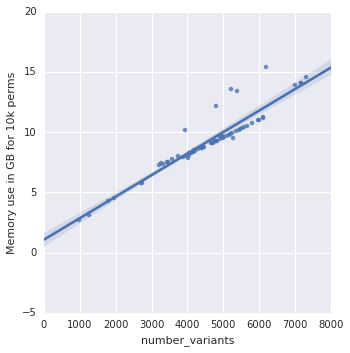

In [648]:
sns.lmplot(x='number_variants', y='mem_use_norm', data=t)
plt.ylabel('Memory use in GB for 10k perms');

In [599]:
import statsmodels.api as sm

In [600]:
x = t.number_variants
y = t.mem_use_norm
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()

In [601]:
results.params

const              1.079206
number_variants    0.001786
dtype: float64

In [583]:
results.params

const              1.079206
number_variants    0.001786
dtype: float64

In [582]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           mem_use_norm   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     431.2
Date:                Thu, 10 Dec 2015   Prob (F-statistic):           7.08e-30
Time:                        15:27:12   Log-Likelihood:                -83.565
No. Observations:                  65   AIC:                             171.1
Df Residuals:                      63   BIC:                             175.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const               1.0792      0.411      2.627      0.011         0.258     1.900
number_variants     0.0018    8.6e-05     20.766      0.000         0.002     0.002
==============================================================================
Omnibus:                       50.469   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              160.966
Skew:                           2.493   Prob(JB):                     1.11e-35
Kurtosis:                       8.880   Cond. No.                     1.78e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.78e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""